In [0]:
# Reference: https://github.com/Sundar0989/EndtoEnd---Predictive-modeling-using-Python/blob/master/EndtoEnd%20code%20for%20Predictive%20model.ipynb 

# 1. Load Dataset

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

# /content/gdrive/My Drive/AI/dataset/bank_data/bank.xlsx

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import pandas as pd
import numpy as np

df = pd.read_excel("/content/gdrive/My Drive/AI/dataset/bank_data/bank.xlsx")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


# 2. Convert Target to 1/0

In [0]:
df['target'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [6]:
df.target.value_counts()

0    4000
1     521
Name: target, dtype: int64

In [0]:
df.drop('y',axis=1,inplace=True)

# 3. Descriptive Stats

In [8]:
df.target.value_counts()/len(df)

0    0.88476
1    0.11524
Name: target, dtype: float64

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,target
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579,0.115240
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562,0.319347
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


In [10]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
target        int64
dtype: object

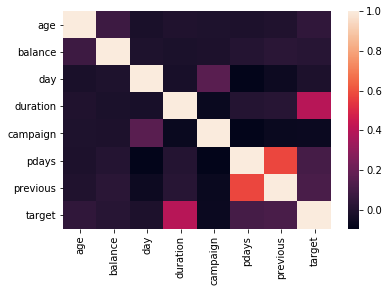

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# 4. Variable Selection using Python - Vote based approach

In [0]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i].fillna('NA'))

In [0]:
features = df[df.columns.difference(['target'])]
labels = df['target']

In [0]:
features = features.fillna(0)

## 4.1 WOE and IV

In [0]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [0]:
final_iv, IV = data_vars(df[df.columns.difference(['target'])],df.target)

In [17]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,19,39,2290,259,0.113100,2031,0.886900,0.497121,0.50775,-0.021156,0.000452
1,age,40,87,2231,262,0.117436,1969,0.882564,0.502879,0.49225,0.021363,0.000452
2,balance,-3313,69,1133,94,0.082966,1039,0.917034,0.180422,0.25975,-0.364420,0.076208
3,balance,70,444,1128,106,0.093972,1022,0.906028,0.203455,0.25550,-0.227778,0.076208
4,balance,445,1480,1131,149,0.131742,982,0.868258,0.285988,0.24550,0.152655,0.076208
5,balance,1482,71188,1129,172,0.152347,957,0.847653,0.330134,0.23925,0.321991,0.076208
6,campaign,1,2,2998,378,0.126084,2620,0.873916,0.725528,0.65500,0.102264,0.023342
7,campaign,3,50,1523,143,0.093894,1380,0.906106,0.274472,0.34500,-0.228695,0.023342
8,contact,0,1,3197,460,0.143885,2737,0.856115,0.882917,0.68425,0.254908,0.247734
9,contact,2,2,1324,61,0.046073,1263,0.953927,0.117083,0.31575,-0.992072,0.247734


In [18]:
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
6,duration,1.651501
3,contact,0.247734
13,pdays,0.203267
15,previous,0.177081
8,housing,0.106556
1,balance,0.076208
10,loan,0.060791
7,education,0.024649
2,campaign,0.023342
11,marital,0.019556


### Apply WOE values to your dataframe columns

The below code snippet can be used to apply the WOE values to your dataframe columns. 

In [0]:
transform_vars_list = df.columns.difference(['target'])
transform_prefix = 'new_' # leave this value blank if you need replace the original column values

In [20]:
transform_vars_list

Index(['age', 'balance', 'campaign', 'contact', 'day', 'default', 'duration',
       'education', 'housing', 'job', 'loan', 'marital', 'month', 'pdays',
       'poutcome', 'previous'],
      dtype='object')

In [0]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
        except:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))

## 4.2 Variable Importance using Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9931431099314311


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [24]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
6,duration,0.279704
1,balance,0.109292
0,age,0.105452
4,day,0.089933
12,month,0.085041
13,pdays,0.058503
9,job,0.046411
14,poutcome,0.044432
2,campaign,0.039661
11,marital,0.032346


## 4.3 Recursive Feature Elimination

In [25]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [27]:
Selected[Selected['RFE'] == True]

,index,RFE
0,age,True
1,balance,True
2,campaign,True
3,contact,True
4,day,True
5,default,True
6,duration,True
7,education,True
8,housing,True
9,job,True


## 4.4 Variable Importance using Extratrees Classifier

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.08992161 0.07964412 0.05832016 0.02654082 0.09602414 0.00595323
 0.25408455 0.04806757 0.02219431 0.05966587 0.01345551 0.03718881
 0.08602275 0.03632086 0.05690074 0.02969493]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [0]:
FI = FI.reset_index()

In [31]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
6,duration,0.254085
4,day,0.096024
0,age,0.089922
12,month,0.086023
1,balance,0.079644
9,job,0.059666
2,campaign,0.058320
14,poutcome,0.056901
7,education,0.048068
11,marital,0.037189


## 4.5 Chi Square

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features.abs(), labels)

In [0]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)

In [0]:
chi_sq = chi_sq.reset_index()

In [35]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
6,duration,186041.90
13,pdays,11573.63
1,balance,7997.11
15,previous,325.48
3,contact,100.51
2,campaign,58.50
0,age,24.97
8,housing,21.50
10,loan,19.05
12,month,12.33


## 4.6 L1 feature selection

In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

In [0]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()

In [38]:
l1[l1['L1'] == True]

,index,L1
0,age,True
2,campaign,True
3,contact,True
4,day,True
6,duration,True
8,housing,True
9,job,True
10,loan,True
11,marital,True
12,month,True


## 4.7 Combine all together

In [0]:
from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

## 4.8 Vote each variable

In [0]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [0]:
score_table['final_score'] = score_table.sum(axis=1)

In [42]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
6,duration,1,1,1,1,1,1,6
0,age,0,1,1,0,1,1,4
1,balance,0,1,1,1,1,0,4
3,contact,1,0,0,1,1,1,4
4,day,0,1,1,0,1,1,4
12,month,0,1,1,0,1,1,4
13,pdays,1,0,0,1,1,1,4
15,previous,1,0,0,1,1,1,4
8,housing,1,0,0,0,1,1,3
2,campaign,0,0,0,0,1,1,2


## 4.9 Multicollinearity

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [0]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [0]:
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

In [0]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

In [47]:
list(vif['Features'])

['age',
 'balance',
 'campaign',
 'contact',
 'day',
 'duration',
 'housing',
 'job',
 'loan',
 'marital',
 'month',
 'pdays',
 'previous']

## Descriptive Stats and Visualization - For selected variables

In [0]:
final_vars = list(vif['Features']) + ['target']

In [0]:
df1 = df[final_vars].fillna(0)

In [50]:
df1.describe()

,age,balance,campaign,contact,day,duration,housing,job,loan,marital,month,pdays,previous,target
count,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00
mean,41.17,1422.66,2.79,0.65,15.92,263.96,0.57,4.41,0.15,1.15,5.54,39.77,0.54,0.12
std,10.58,3009.64,3.11,0.90,8.25,259.86,0.50,3.26,0.36,0.60,3.00,100.12,1.69,0.32
min,19.00,-3313.00,1.00,0.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00
25%,33.00,69.00,1.00,0.00,9.00,104.00,0.00,1.00,0.00,1.00,3.00,-1.00,0.00,0.00
50%,39.00,444.00,2.00,0.00,16.00,185.00,1.00,4.00,0.00,1.00,6.00,-1.00,0.00,0.00
75%,49.00,1480.00,3.00,2.00,21.00,329.00,1.00,7.00,0.00,2.00,8.00,-1.00,0.00,0.00
max,87.00,71188.00,50.00,2.00,31.00,3025.00,1.00,11.00,1.00,2.00,11.00,871.00,25.00,1.00


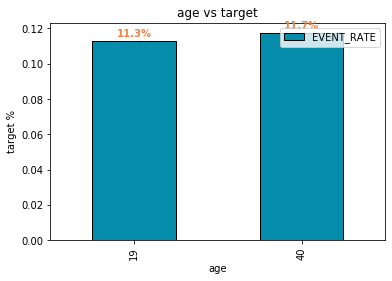

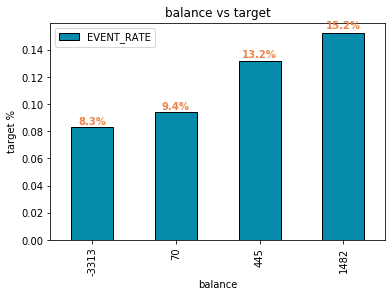

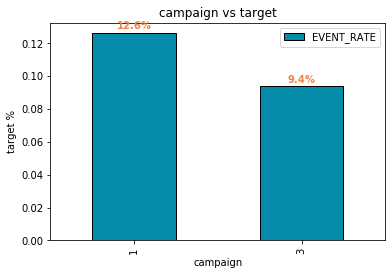

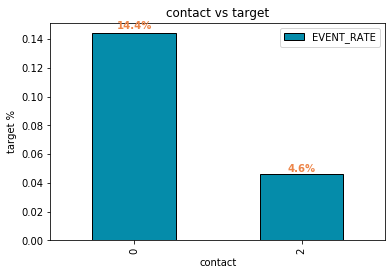

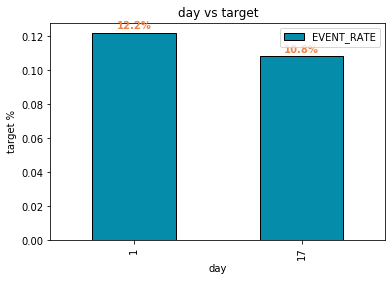

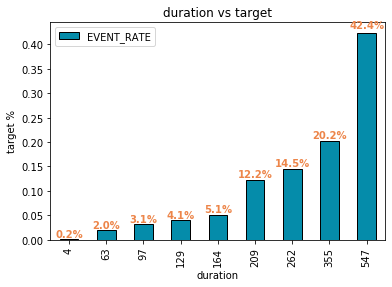

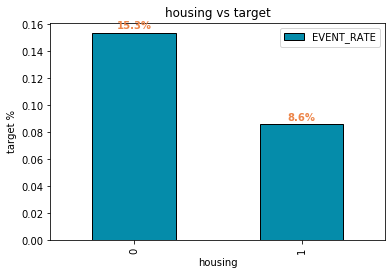

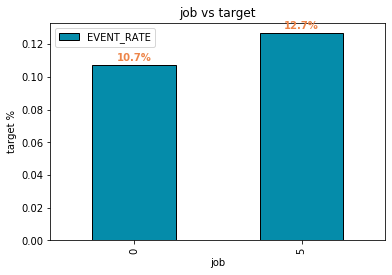

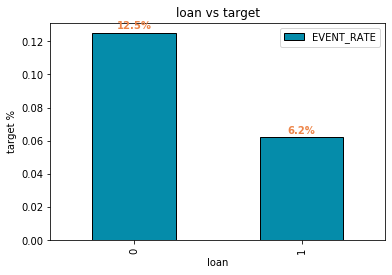

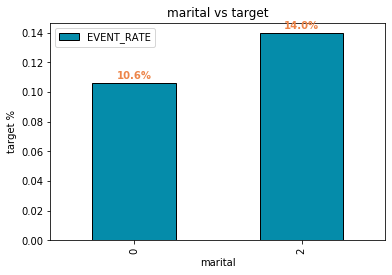

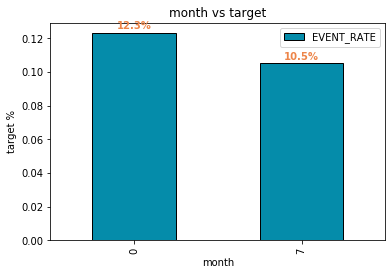

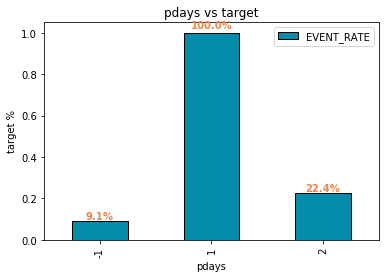

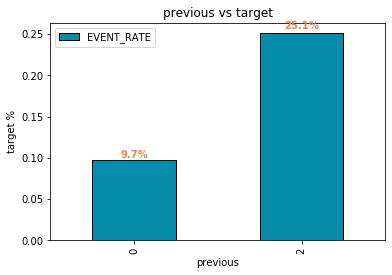

In [51]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['target'])
final_iv = final_iv[(final_iv.VAR_NAME != 'target')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

# 5. Model

In [0]:
#from sklearn.cross_validation import train_test_split

from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['target']
features_test = test[list(vif['Features'])]
label_test = test['target']

## Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9918879056047197 0.8844665561083471 0.9997093922548349 0.8369397540129248


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [55]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2400,1
1,21,290


In [56]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1562,37
1,172,38


## Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8882743362831859 0.8955223880597015 0.8589226621812186 0.8527234283331844


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [58]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2359,42
1,261,50


In [59]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1571,28
1,161,49


## Neural Network

In [60]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.7765486725663717 0.7650635710337202 0.8254692913322557 0.8204979302540278


In [61]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1869,532
1,74,237


In [62]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1223,376
1,49,161


## Naive Bayes

In [63]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8421828908554573 0.8524046434494196 0.8155832711718457 0.8218797462699902


In [64]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2163,238
1,190,121


In [65]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1450,149
1,118,92


## Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9387905604719764 0.8833609729132117 0.9588587783436531 0.8869214159722644


In [0]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2369,27
1,139,177


In [0]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1535,69
1,142,63


# 6. Performance Tuning

# Random Forest - Hyper parameter tuning

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.1s finished


In [67]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**rf_random.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9402654867256637 0.8911000552791598 0.9819836590059607 0.869665564787516


## Gradient Boosting - Hyper parameter tuning

In [71]:
!pip install sklearn

In [72]:
#from sklearn import cross_validation, metrics   
from sklearn.model_selection import cross_validate

#from sklearn.grid_search import GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

gb = GradientBoostingClassifier()

gf_tune = GridSearchCV(estimator = gb, param_grid = grid, cv = 2, verbose=2, n_jobs = -1)
gf_tune.fit(features_train, label_train)

print(gf_tune.best_params_)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.9min finished


{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 445}


In [73]:
print(gf_tune.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 445}


In [74]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(**gf_tune.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

1.0 0.8888888888888888 1.0 0.8973227314690729


# 7. Final Model and Model Performance

In [75]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8882743362831859 0.8955223880597015 0.8589226621812186 0.8527234283331844


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [76]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2359,42
1,261,50


In [77]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1571,28
1,161,49


In [79]:
!pip install bokeh

In [80]:
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Train data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)

show(p)

In [81]:
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Test data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

## Decile Plots and KS statistic

In [0]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [0]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [0]:
scores_train = scoring(features_train,clf,label_train)
scores_test = scoring(features_test,clf,label_test)

In [85]:
deciling(scores_train,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,272,129,143,47.4265,129,143,41.4791,5.95585,35.5232
2.0,271,85,186,31.3653,214,329,68.8103,13.7026,55.1077
3.0,271,35,236,12.9151,249,565,80.0643,23.5319,56.5324
4.0,271,22,249,8.11808,271,814,87.1383,33.9025,53.2357
5.0,271,18,253,6.64207,289,1067,92.926,44.4398,48.4862
6.0,271,7,264,2.58303,296,1331,95.1768,55.4352,39.7416
7.0,271,10,261,3.69004,306,1592,98.3923,66.3057,32.0866
8.0,271,2,269,0.738007,308,1861,99.0354,77.5094,21.526


In [86]:
deciling(scores_test,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,181,91,90,50.2762,91,90,43.3333,5.62852,37.7048
2.0,181,43,138,23.7569,134,228,63.8095,14.2589,49.5506
3.0,181,35,146,19.337,169,374,80.4762,23.3896,57.0866
4.0,181,13,168,7.18232,182,542,86.6667,33.8962,52.7705
5.0,180,11,169,6.11111,193,711,91.9048,44.4653,47.4395
6.0,181,4,177,2.20994,197,888,93.8095,55.5347,38.2748
7.0,181,8,173,4.41989,205,1061,97.619,66.354,31.2651
8.0,181,4,177,2.20994,209,1238,99.5238,77.4234,22.1004


## Lift chart, Actual vs predicted and Gains chart

In [0]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

def plots(agg1,target,type):

    plt.figure(1,figsize=(20, 5))

    plt.subplot(131)
    plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
    plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
    plt.xticks(range(10,110,10))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

    plt.subplot(132)
    X = agg1['DECILE'].tolist()
    X.append(0)
    Y = agg1['DIST_TAR'].tolist()
    Y.append(0)
    plt.plot(sorted(X),sorted(Y))
    plt.plot([0, 100], [0, 100],'r--')
    plt.xticks(range(0,110,10))
    plt.yticks(range(0,110,10))
    plt.grid(True)
    plt.title('Gains Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
    plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
            xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
    plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
            xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

    plt.subplot(133)
    plt.plot(agg1['DECILE'],agg1['LIFT'])
    plt.xticks(range(10,110,10))
    plt.grid(True)
    plt.title('Lift Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel("Lift",fontsize=15)

    plt.tight_layout()

In [0]:
def gains(data,decile_by,target,score):
    inputs = list(decile_by)
    inputs.extend((target,score))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['ACTUAL'] = grouped.mean()[target]*100
    agg1['PRED'] = grouped.mean()[score]*100
    agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
    agg1.index.name = 'DECILE'
    agg1 = agg1.reset_index()
    agg1['DECILE'] = agg1['DECILE']*10
    agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
    plots(agg1,target,'Distribution')

In [0]:
lift_train = pd.concat([features_train,scores_train],axis=1)
lift_test = pd.concat([features_test,scores_test],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version


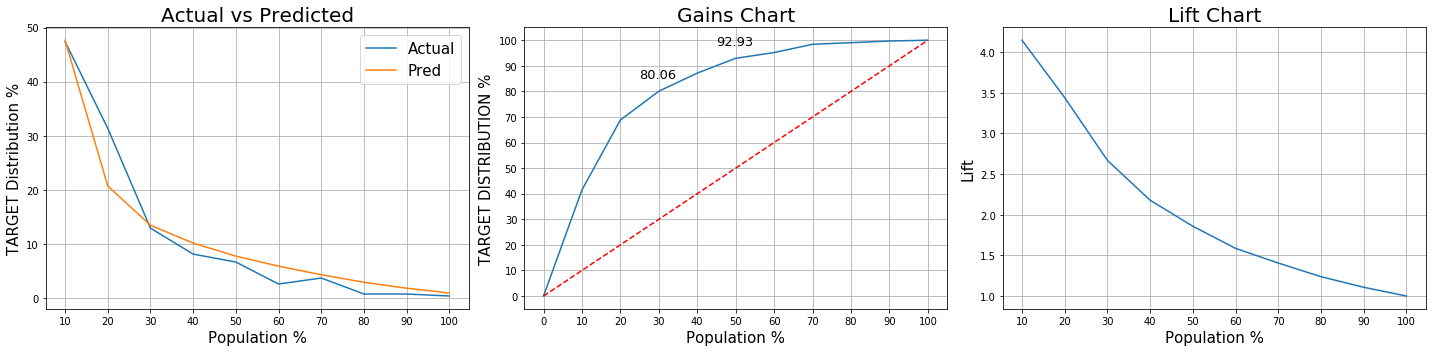

In [90]:
gains(lift_train,['DECILE'],'TARGET','SCORE')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version


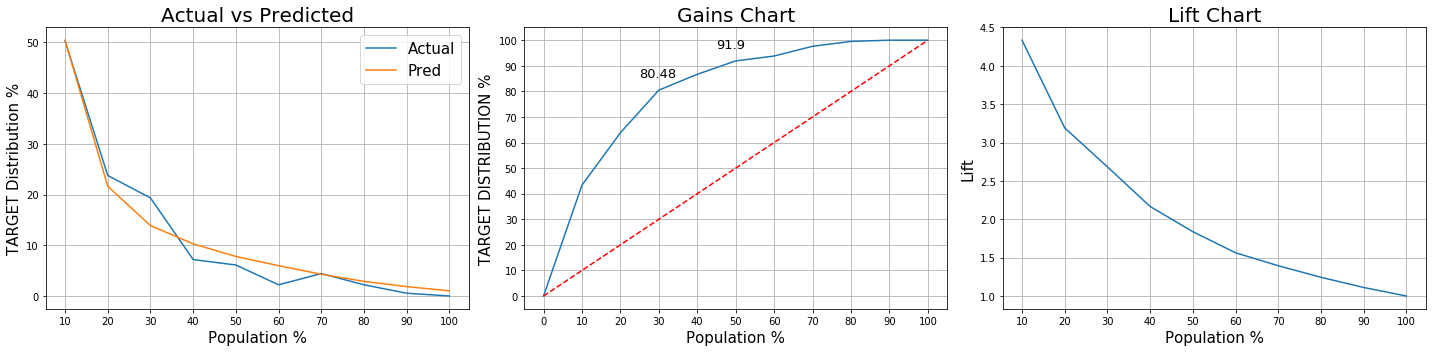

In [91]:
gains(lift_test,['DECILE'],'TARGET','SCORE')

# Save Model for future use

In [92]:
import pandas
from sklearn.externals import joblib

filename = 'final_model.model'
i = [d,clf]
joblib.dump(i,filename)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['final_model.model']

# Score New data

In [0]:
# Use the code to load the model
filename = 'final_model.model'

from sklearn.externals import joblib
d,clf=joblib.load(filename)

In [0]:
def score_new(features,clf):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    return(score)

In [96]:
d

defaultdict(sklearn.preprocessing.label.LabelEncoder,
            {'contact': LabelEncoder(),
             'default': LabelEncoder(),
             'education': LabelEncoder(),
             'housing': LabelEncoder(),
             'job': LabelEncoder(),
             'loan': LabelEncoder(),
             'marital': LabelEncoder(),
             'month': LabelEncoder(),
             'poutcome': LabelEncoder()})

In [97]:
type(d)

collections.defaultdict

In [0]:
scores = score_new(features,clf)

In [99]:
scores

,SCORE,DECILE
0,0.11,4.00
1,0.12,3.00
2,0.10,4.00
3,0.01,10.00
4,0.02,9.00
...,...,...
4516,0.07,5.00
4517,0.01,10.00
4518,0.05,6.00
4519,0.16,3.00
